In [1]:
# Colab: install Kaggle CLI + make folders
!pip -q install kaggle
import os, json, textwrap, pathlib

BASE = pathlib.Path(".")
RAW = BASE/"data"/"raw"
OUT = BASE/"results"/"outputs"
for p in [RAW, OUT]:
    p.mkdir(parents=True, exist_ok=True)

# 🔑 Upload kaggle.json when prompted (from your Kaggle account > Settings > API)
from google.colab import files
print("Upload your kaggle.json (from Kaggle > Settings > Create New API Token)")
uploaded = files.upload()

# Save creds with correct permissions
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
with open(os.path.expanduser("~/.kaggle/kaggle.json"), "wb") as f:
    f.write(uploaded["kaggle.json"])
os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)

# Download dataset
!kaggle datasets download -d aakashpatil10/finance-default-prediction -p data/raw -o
!unzip -o -d data/raw data/raw/finance-default-prediction.zip


Upload your kaggle.json (from Kaggle > Settings > Create New API Token)


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/aakashpatil10/finance-default-prediction
License(s): apache-2.0
  0% 0.00/15.4k [00:00<?, ?B/s]
100% 15.4k/15.4k [00:00<00:00, 69.6MB/s]
Archive:  data/raw/finance-default-prediction.zip
  inflating: data/raw/finance_default_prediction.csv  


In [2]:
import pandas as pd, numpy as np, glob, os, re, matplotlib.pyplot as plt

# Pick the first CSV found (adjust if needed)
csvs = glob.glob(str(RAW/"*.csv"))
assert len(csvs)>0, "No CSVs found in data/raw."
CSV_NAME = csvs[0]
print("Using:", os.path.basename(CSV_NAME))

df = pd.read_csv(CSV_NAME)
print("Shape:", df.shape)
display(df.head(3))
df.info()


Using: finance_default_prediction.csv
Shape: (1000, 8)


,CustomerID,Age,AnnualIncome,LoanAmount,CreditScore,LoanTerm,ExistingDebt,Default
0,1,21,80448,27761,817,36,10975,0
1,2,57,49434,41546,828,36,35616,1
2,3,55,101896,41712,497,60,22864,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   CustomerID    1000 non-null   int64
 1   Age           1000 non-null   int64
 2   AnnualIncome  1000 non-null   int64
 3   LoanAmount    1000 non-null   int64
 4   CreditScore   1000 non-null   int64
 5   LoanTerm      1000 non-null   int64
 6   ExistingDebt  1000 non-null   int64
 7   Default       1000 non-null   int64
dtypes: int64(8)
memory usage: 62.6 KB


Guessed TARGET: Default
Counts:
 Default
0    385
1    615
Name: count, dtype: int64
Ratios:
 Default
neg(0)    0.385
pos(1)    0.615
Name: count, dtype: float64


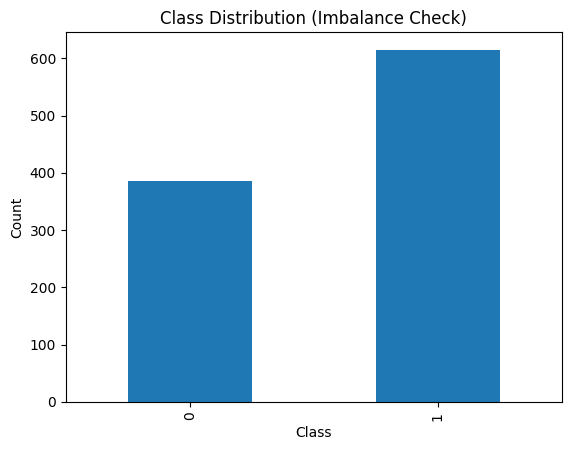

In [3]:
# Try to infer the target column name
candidates = [c for c in df.columns if re.search(r'(default|defaulter|loan_default|is_default|target|label)', c, re.I)]
TARGET = candidates[0] if candidates else None
print("Guessed TARGET:", TARGET)
# If wrong, set manually, e.g.:
# TARGET = "default"

assert TARGET in df.columns, "Set TARGET manually to your binary target column."

# Ensure binary numeric (0/1)
y_raw = df[TARGET]
if not set(np.unique(y_raw.dropna())).issubset({0,1}):
    # Try to coerce (e.g., 'Yes'/'No', 'Y'/'N')
    mapping = {'yes':1,'y':1,'true':1,'t':1,'default':1,
               'no':0,'n':0,'false':0,'f':0,'non-default':0}
    y = y_raw.astype(str).str.lower().map(mapping)
    if y.isna().mean()<0.05:
        df[TARGET] = y.astype(int)
    else:
        raise ValueError("Target not binary—please clean/encode it first.")

# Class ratio
class_counts = df[TARGET].value_counts().sort_index()
class_ratio = (class_counts / class_counts.sum()).rename({0:"neg(0)", 1:"pos(1)"})
print("Counts:\n", class_counts)
print("Ratios:\n", class_ratio.round(4))

# Simple bar to show imbalance
ax = class_counts.plot(kind="bar")
ax.set_xlabel("Class")
ax.set_ylabel("Count")
ax.set_title("Class Distribution (Imbalance Check)")
plt.show()


In [4]:
# Balance full df so class 0 and 1 have equal counts
!pip -q install imbalanced-learn

import pandas as pd, numpy as np, pathlib
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# --- settings ---
TARGET = "Default"   # change if your target column name differs
SAVE = pathlib.Path("results/outputs"); SAVE.mkdir(parents=True, exist_ok=True)

X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

print("Before:", y.value_counts().to_dict())

# 1) Oversample minority to match majority (more rows)
ros = RandomOverSampler(random_state=42)             # sampling_strategy='auto' -> minority up to majority
X_over, y_over = ros.fit_resample(X, y)
df_over = pd.concat([pd.DataFrame(X_over, columns=X.columns),
                     pd.Series(y_over, name=TARGET)], axis=1)
df_over.to_csv(SAVE/"df_balanced_over.csv", index=False)
print("After (oversample):", df_over[TARGET].value_counts().to_dict())

# 2) Undersample majority to match minority (fewer rows)
rus = RandomUnderSampler(random_state=42)            # sampling_strategy='auto' -> majority down to minority
X_under, y_under = rus.fit_resample(X, y)
df_under = pd.concat([pd.DataFrame(X_under, columns=X.columns),
                      pd.Series(y_under, name=TARGET)], axis=1)
df_under.to_csv(SAVE/"df_balanced_under.csv", index=False)
print("After (undersample):", df_under[TARGET].value_counts().to_dict())

print("Saved:", SAVE/"df_balanced_over.csv", "and", SAVE/"df_balanced_under.csv")


Before: {1: 615, 0: 385}
After (oversample): {0: 615, 1: 615}
After (undersample): {0: 385, 1: 385}
Saved: results/outputs/df_balanced_over.csv and results/outputs/df_balanced_under.csv


Saved: results/outputs/df_balanced_over.csv and results/outputs/df_balanced_under.csv

[oversample] counts: {0: 615, 1: 615}


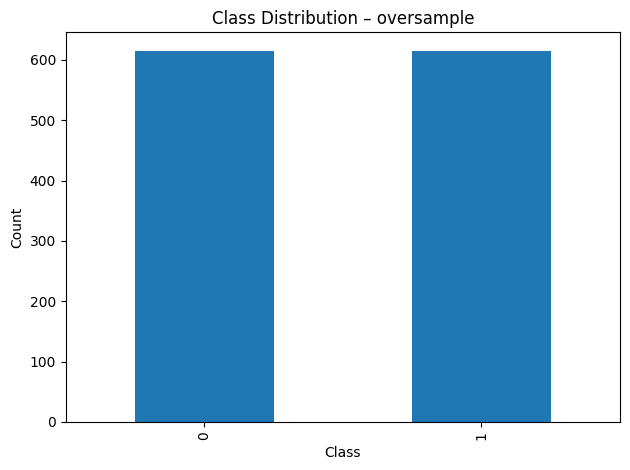


[undersample] counts: {0: 385, 1: 385}


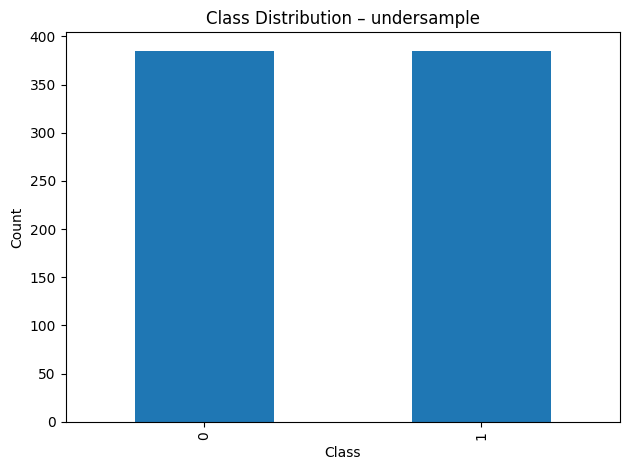

In [5]:
# --- Oversample & Undersample WHOLE df, then check imbalance ---
!pip -q install imbalanced-learn

import pandas as pd, numpy as np, pathlib, matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

TARGET = "Default"  # ← change if your target column name is different
SAVE = pathlib.Path("results/outputs"); SAVE.mkdir(parents=True, exist_ok=True)
VIS  = pathlib.Path("results/eda_visualizations"); VIS.mkdir(parents=True, exist_ok=True)

X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

# 1) Oversample minority → match majority
ros = RandomOverSampler(random_state=42)
X_over, y_over = ros.fit_resample(X, y)
df_over = pd.concat([pd.DataFrame(X_over, columns=X.columns),
                     pd.Series(y_over, name=TARGET)], axis=1)
df_over.to_csv(SAVE/"df_balanced_over.csv", index=False)

# 2) Undersample majority → match minority
rus = RandomUnderSampler(random_state=42)
X_under, y_under = rus.fit_resample(X, y)
df_under = pd.concat([pd.DataFrame(X_under, columns=X.columns),
                      pd.Series(y_under, name=TARGET)], axis=1)
df_under.to_csv(SAVE/"df_balanced_under.csv", index=False)

print("Saved:", SAVE/"df_balanced_over.csv", "and", SAVE/"df_balanced_under.csv")

# --- Re-check imbalance (only these two) ---
for name, d in [("oversample", df_over), ("undersample", df_under)]:
    vc = d[TARGET].value_counts().sort_index()
    print(f"\n[{name}] counts:", vc.to_dict())
    ax = vc.plot(kind="bar")
    ax.set_title(f"Class Distribution – {name}")
    ax.set_xlabel("Class"); ax.set_ylabel("Count")
    plt.tight_layout()
    plt.savefig(VIS/f"class_dist_{name}.png", dpi=160)
    plt.show()


In [6]:
import re, glob, os, pathlib, pandas as pd, numpy as np

SAVE = pathlib.Path("results/outputs"); SAVE.mkdir(parents=True, exist_ok=True)

# If you already set TARGET/DATE_COL earlier, this will reuse them.
# Otherwise we try to guess TARGET; and try to find a date column.
if 'TARGET' not in globals():
    guesses = [c for c in df.columns if re.search(r'(default|defaulter|loan_default|is_default|target|label)', c, re.I)]
    TARGET = guesses[0] if guesses else None
print("TARGET =", TARGET)

# Set manually if guess is wrong:
# TARGET = "Default"  # <-- uncomment & edit if needed

assert TARGET in df.columns, "Please set TARGET to your binary target column name."

# Try to find a date column if not set
if 'DATE_COL' not in globals() or DATE_COL is None:
    date_candidates = []
    for c in df.columns:
        if re.search(r'(date|time|month|year|timestamp)', c, re.I):
            try:
                pd.to_datetime(df[c], errors="raise")
                date_candidates.append(c)
            except:
                pass
    DATE_COL = date_candidates[0] if date_candidates else None
print("DATE_COL =", DATE_COL)

# make sure target is 0/1 integers
df[TARGET] = df[TARGET].astype(int)


TARGET = Default
DATE_COL = None


In [7]:
# == CONFIG ==
TARGET = "Default"          # <-- set to your target column name
DATE_COL = None             # <-- set like "application_date" if you know it; else we'll try to auto-detect
BALANCE_METHOD = "over"     # "over" or "under"
TEST_FRAC = 0.15
VAL_FRAC  = 0.15
RANDOM_STATE = 42

# == IMPORTS ==
!pip -q install imbalanced-learn
import re, pathlib, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

SAVE_DIR = pathlib.Path("results/outputs"); SAVE_DIR.mkdir(parents=True, exist_ok=True)

# == 0) Sanity: find TARGET / DATE ==
if TARGET not in df.columns:
    guesses = [c for c in df.columns if re.search(r'(default|defaulter|loan_default|is_default|target|label)', c, re.I)]
    assert guesses, "TARGET not in df; set TARGET to your label column."
    TARGET = guesses[0]

if DATE_COL is None:
    # try to find a parseable date column
    cands = []
    for c in df.columns:
        if re.search(r'(date|time|month|year|timestamp)', c, re.I):
            try:
                pd.to_datetime(df[c], errors="raise")
                cands.append(c)
            except:
                pass
    DATE_COL = cands[0] if cands else None

print("TARGET  :", TARGET)
print("DATE_COL:", DATE_COL)

# ensure binary ints 0/1
df[TARGET] = df[TARGET].astype(int)

# == helper for logging ==
def brief(y, name):
    vc = y.value_counts().sort_index()
    r = (vc / vc.sum()).to_dict()
    print(f"{name:>6} | n={len(y):>5} | 0={vc.get(0,0):>5} 1={vc.get(1,0):>5} | pos_ratio={r.get(1,0):.4f}")

# == 1) Split: temporal if DATE_COL else stratified ==
X = df.drop(columns=[TARGET])
y = df[TARGET]

if DATE_COL:
    dfx = df[[DATE_COL, TARGET]].copy()
    dfx[DATE_COL] = pd.to_datetime(dfx[DATE_COL], errors="coerce")
    order = dfx[DATE_COL].sort_values().index

    n = len(order)
    n_test = int(round(n * TEST_FRAC))
    n_val  = int(round(n * VAL_FRAC))

    test_idx  = order[-n_test:]
    val_idx   = order[-(n_test+n_val):-n_test]
    train_idx = order[:-(n_test+n_val)]

    X_train, y_train = X.loc[train_idx], y.loc[train_idx]
    X_val,   y_val   = X.loc[val_idx],   y.loc[val_idx]
    X_test,  y_test  = X.loc[test_idx],  y.loc[test_idx]
else:
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=TEST_FRAC, stratify=y, random_state=RANDOM_STATE
    )
    # we want overall 15% val; from the remaining (1-TEST_FRAC) block, the share is:
    val_share_in_temp = VAL_FRAC / (1 - TEST_FRAC)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_share_in_temp, stratify=y_temp, random_state=RANDOM_STATE
    )

print("\nBefore balancing (class ratios):")
brief(y_train, "train")
brief(y_val,   "val")
brief(y_test,  "test")

# == 2) Balance TRAIN ONLY ==
if BALANCE_METHOD.lower() == "over":
    balancer = RandomOverSampler(random_state=RANDOM_STATE)
    suffix = "over"
elif BALANCE_METHOD.lower() == "under":
    balancer = RandomUnderSampler(random_state=RANDOM_STATE)
    suffix = "under"
else:
    raise ValueError("BALANCE_METHOD must be 'over' or 'under'.")

X_train_bal, y_train_bal = balancer.fit_resample(X_train, y_train)

print("\nAfter balancing TRAIN (1:1):")
brief(pd.Series(y_train_bal), "train*")

# == 3) Save outputs ==
train_df = X_train.copy(); train_df[TARGET] = y_train.values
val_df   = X_val.copy();   val_df[TARGET]   = y_val.values
test_df  = X_test.copy();  test_df[TARGET]  = y_test.values
train_bal_df = pd.DataFrame(X_train_bal, columns=X_train.columns)
train_bal_df[TARGET] = y_train_bal

paths = {
    "train_split.csv": train_df,
    "val_split.csv":   val_df,
    "test_split.csv":  test_df,
    f"train_balanced_{suffix}.csv": train_bal_df
}
for fname, d in paths.items():
    p = SAVE_DIR / fname
    d.to_csv(p, index=False)
    print("Saved:", p)


TARGET  : Default
DATE_COL: None

Before balancing (class ratios):
 train | n=  700 | 0=  269 1=  431 | pos_ratio=0.6157
   val | n=  150 | 0=   58 1=   92 | pos_ratio=0.6133
  test | n=  150 | 0=   58 1=   92 | pos_ratio=0.6133

After balancing TRAIN (1:1):
train* | n=  862 | 0=  431 1=  431 | pos_ratio=0.5000
Saved: results/outputs/train_split.csv
Saved: results/outputs/val_split.csv
Saved: results/outputs/test_split.csv
Saved: results/outputs/train_balanced_over.csv


In [8]:
import pandas as pd
t = pd.read_csv("results/outputs/train_balanced_over.csv")
t["Default"].value_counts()


,count
Default,
0,431
1,431


**Missing values**

In [9]:
# Config & load splits (prefers your balanced train)

import pandas as pd, numpy as np, pathlib, os, re, matplotlib.pyplot as plt
SAVE_OUT = pathlib.Path("results/outputs"); SAVE_OUT.mkdir(parents=True, exist_ok=True)
SAVE_VIZ = pathlib.Path("results/eda_visualizations"); SAVE_VIZ.mkdir(parents=True, exist_ok=True)

# set/confirm target
TARGET = "Default"  # change if needed

# load splits (balanced train if available)
p_train_bal = SAVE_OUT/"train_balanced_over.csv"   # or ..._under.csv if you used under
p_train     = SAVE_OUT/"train_split.csv"
p_val       = SAVE_OUT/"val_split.csv"
p_test      = SAVE_OUT/"test_split.csv"

if p_train_bal.exists():
    train = pd.read_csv(p_train_bal)
    print("Loaded:", p_train_bal)
else:
    train = pd.read_csv(p_train)
    print("Loaded:", p_train)

val  = pd.read_csv(p_val);  print("Loaded:", p_val)
test = pd.read_csv(p_test); print("Loaded:", p_test)

assert TARGET in train.columns, "TARGET not found in train."


Loaded: results/outputs/train_balanced_over.csv
Loaded: results/outputs/val_split.csv
Loaded: results/outputs/test_split.csv


[train] shape=(862, 7)  columns with any nulls: 0


,null_frac,null_pct
CustomerID,0.0,0.0
Age,0.0,0.0
AnnualIncome,0.0,0.0
LoanAmount,0.0,0.0
CreditScore,0.0,0.0
LoanTerm,0.0,0.0
ExistingDebt,0.0,0.0


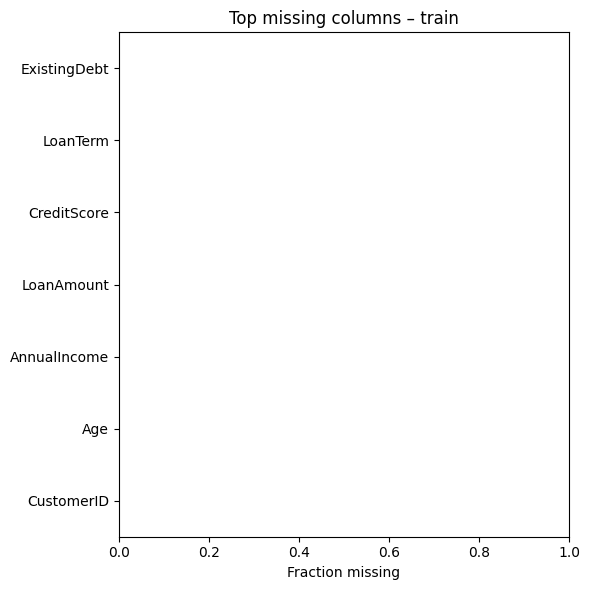

[val] shape=(150, 7)  columns with any nulls: 0


,null_frac,null_pct
CustomerID,0.0,0.0
Age,0.0,0.0
AnnualIncome,0.0,0.0
LoanAmount,0.0,0.0
CreditScore,0.0,0.0
LoanTerm,0.0,0.0
ExistingDebt,0.0,0.0


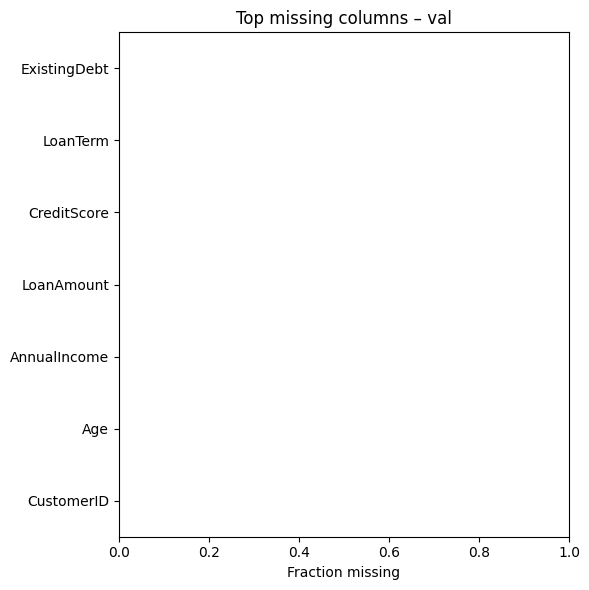

[test] shape=(150, 7)  columns with any nulls: 0


,null_frac,null_pct
CustomerID,0.0,0.0
Age,0.0,0.0
AnnualIncome,0.0,0.0
LoanAmount,0.0,0.0
CreditScore,0.0,0.0
LoanTerm,0.0,0.0
ExistingDebt,0.0,0.0


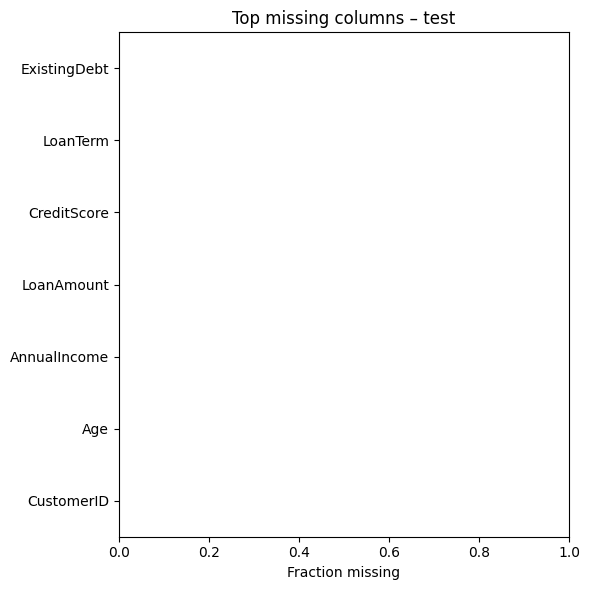

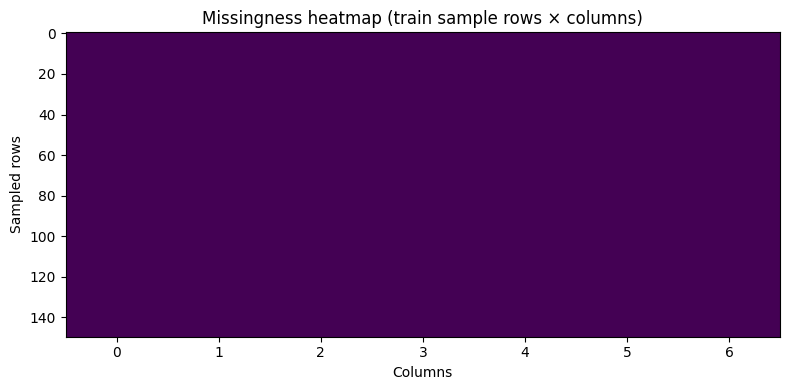

In [10]:
#Missingness audit (top columns, plots, CSV report)

def missing_summary(df, name):
    ms = df.isna().mean().sort_values(ascending=False).to_frame("null_frac")
    ms["null_pct"] = (100*ms["null_frac"]).round(2)
    ms.to_csv(SAVE_OUT/f"missing_summary_{name}.csv")
    print(f"[{name}] shape={df.shape}  columns with any nulls: {(ms['null_frac']>0).sum()}")
    display(ms.head(20))
    # bar plot for top-20
    top = ms.head(20)["null_frac"]
    ax = top.plot(kind="barh", figsize=(6,6))
    ax.set_xlim(0,1); ax.set_xlabel("Fraction missing"); ax.set_title(f"Top missing columns – {name}")
    plt.tight_layout(); plt.savefig(SAVE_VIZ/f"missing_top20_{name}.png", dpi=160); plt.show()
    return ms

ms_train = missing_summary(train.drop(columns=[TARGET]), "train")
ms_val   = missing_summary(val.drop(columns=[TARGET]),   "val")
ms_test  = missing_summary(test.drop(columns=[TARGET]),  "test")

# simple heatmap on a sample of rows (helps for viva screenshots)
sample = train.drop(columns=[TARGET]).sample(min(150, len(train)), random_state=7)
plt.figure(figsize=(8,4))
plt.imshow(sample.isna(), aspect="auto", interpolation="nearest")
plt.title("Missingness heatmap (train sample rows × columns)")
plt.xlabel("Columns"); plt.ylabel("Sampled rows")
plt.tight_layout(); plt.savefig(SAVE_VIZ/"missing_heatmap_train.png", dpi=160); plt.show()


In [11]:
# Add _was_missing flags (top K problematic columns)

TOP_K = 10
ms_sorted = ms_train["null_frac"].loc[ms_train["null_frac"].between(0.01, 0.60)]
flag_cols = ms_sorted.head(TOP_K).index.tolist()
print("Columns to flag with _was_missing:", flag_cols)

def add_missing_flags(df, cols):
    df2 = df.copy()
    for c in cols:
        df2[f"{c}_was_missing"] = df2[c].isna().astype(int)
    return df2

train_f = add_missing_flags(train, flag_cols)
val_f   = add_missing_flags(val,   flag_cols)
test_f  = add_missing_flags(test,  flag_cols)


Columns to flag with _was_missing: []


In [12]:
#Impute (fit on TRAIN only → apply to all)

from sklearn.impute import SimpleImputer
import joblib, numpy as np

# split features/target
X_train = train_f.drop(columns=[TARGET]); y_train = train_f[TARGET]
X_val   = val_f.drop(columns=[TARGET]);   y_val   = val_f[TARGET]
X_test  = test_f.drop(columns=[TARGET]);  y_test  = test_f[TARGET]

num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

print("Numeric cols:", len(num_cols), "| Categorical cols:", len(cat_cols))

num_imp = SimpleImputer(strategy="median")
cat_imp = SimpleImputer(strategy="most_frequent")

# fit on TRAIN only
if num_cols:
    X_train[num_cols] = num_imp.fit_transform(X_train[num_cols])
    X_val[num_cols]   = num_imp.transform(X_val[num_cols])
    X_test[num_cols]  = num_imp.transform(X_test[num_cols])

if cat_cols:
    X_train[cat_cols] = cat_imp.fit_transform(X_train[cat_cols])
    X_val[cat_cols]   = cat_imp.transform(X_val[cat_cols])
    X_test[cat_cols]  = cat_imp.transform(X_test[cat_cols])

# save imputers (for group pipeline reproducibility)
joblib.dump(num_imp, SAVE_OUT/"imputer_numeric_median.pkl")
joblib.dump(cat_imp, SAVE_OUT/"imputer_categorical_mostfreq.pkl")
print("Saved imputers to results/outputs/")


Numeric cols: 7 | Categorical cols: 0
Saved imputers to results/outputs/


In [13]:
#Sanity check (no nulls left?) + save processed CSVs

def post_nulls(df, name):
    n = df.isna().sum().sum()
    print(f"[{name}] remaining NaNs: {n}")
    return n

post_nulls(X_train, "X_train")
post_nulls(X_val,   "X_val")
post_nulls(X_test,  "X_test")

train_proc = X_train.copy(); train_proc[TARGET] = y_train.values
val_proc   = X_val.copy();   val_proc[TARGET]   = y_val.values
test_proc  = X_test.copy();  test_proc[TARGET]  = y_test.values

train_proc.to_csv(SAVE_OUT/"train_missing_handled.csv", index=False)
val_proc.to_csv(  SAVE_OUT/"val_missing_handled.csv",   index=False)
test_proc.to_csv( SAVE_OUT/"test_missing_handled.csv",  index=False)
print("Saved:",
      SAVE_OUT/"train_missing_handled.csv",
      SAVE_OUT/"val_missing_handled.csv",
      SAVE_OUT/"test_missing_handled.csv")


[X_train] remaining NaNs: 0
[X_val] remaining NaNs: 0
[X_test] remaining NaNs: 0
Saved: results/outputs/train_missing_handled.csv results/outputs/val_missing_handled.csv results/outputs/test_missing_handled.csv


**Outliers**

In [14]:
import pandas as pd, numpy as np, pathlib, matplotlib.pyplot as plt, joblib, os

TARGET = "Default"  # change if your target column name differs
OUT = pathlib.Path("results/outputs"); OUT.mkdir(parents=True, exist_ok=True)
VIZ = pathlib.Path("results/eda_visualizations"); VIZ.mkdir(parents=True, exist_ok=True)

def _try(p): return p if p.exists() else None

p_train = _try(OUT/"train_missing_handled.csv") or _try(OUT/"train_split.csv") or _try(OUT/"train_balanced_over.csv")
p_val   = _try(OUT/"val_missing_handled.csv")   or _try(OUT/"val_split.csv")
p_test  = _try(OUT/"test_missing_handled.csv")  or _try(OUT/"test_split.csv")

assert p_train and p_val and p_test, "Could not find split files. Run the split/missing steps first."

train = pd.read_csv(p_train)
val   = pd.read_csv(p_val)
test  = pd.read_csv(p_test)

assert TARGET in train.columns, f"{TARGET} not found."

print("Loaded:", p_train, p_val, p_test, sep="\n- ")

Loaded:
- results/outputs/train_missing_handled.csv
- results/outputs/val_missing_handled.csv
- results/outputs/test_missing_handled.csv


In [15]:
num_cols = train.drop(columns=[TARGET]).select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns:", len(num_cols))

def iqr_bounds(s: pd.Series):
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    low = q1 - 1.5*iqr
    high = q3 + 1.5*iqr
    return low, high, iqr

rows = []
for c in num_cols:
    low, high, iqr = iqr_bounds(train[c].dropna())
    skew = train[c].dropna().skew()
    share_low  = (train[c] < low).mean()
    share_high = (train[c] > high).mean()
    rows.append(dict(column=c, q1_low=low, q3_high=high, iqr=iqr, skew=skew,
                     frac_below=share_low, frac_above=share_high,
                     frac_outliers=share_low+share_high))

outlier_table = pd.DataFrame(rows).sort_values("frac_outliers", ascending=False)
display(outlier_table.head(15))
outlier_table.to_csv(OUT/"outlier_summary_train.csv", index=False)
print("Saved:", OUT/"outlier_summary_train.csv")


Numeric columns: 7


,column,q1_low,q3_high,iqr,skew,frac_below,frac_above,frac_outliers
6,ExistingDebt,-19913.500,44994.500,16227.00,0.868121,0.0,0.006961,0.006961
1,Age,-10.500,97.500,27.00,0.027165,0.0,0.000000,0.000000
0,CustomerID,-468.000,1490.000,489.50,-0.065757,0.0,0.000000,0.000000
2,AnnualIncome,-8127.875,158203.125,41582.75,-0.126631,0.0,0.000000,0.000000
3,LoanAmount,-17701.625,70961.375,22165.75,0.069786,0.0,0.000000,0.000000
4,CreditScore,63.000,1119.000,264.00,-0.227344,0.0,0.000000,0.000000
5,LoanTerm,-12.000,84.000,24.00,-0.064524,0.0,0.000000,0.000000


Saved: results/outputs/outlier_summary_train.csv


Top columns with outliers: ['ExistingDebt']


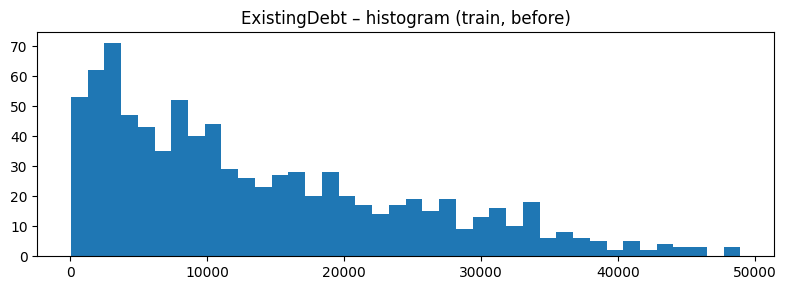

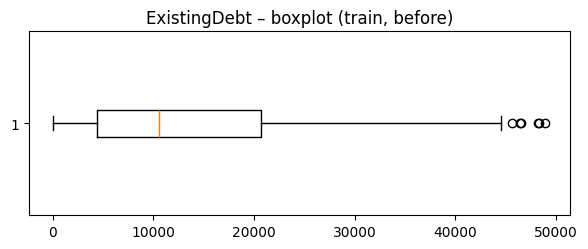

In [16]:
top_cols = outlier_table.query("frac_outliers>0").head(4)["column"].tolist()
print("Top columns with outliers:", top_cols)

for c in top_cols:
    fig = plt.figure(figsize=(8,3))
    plt.hist(train[c].dropna(), bins=40)
    plt.title(f"{c} – histogram (train, before)")
    plt.tight_layout(); plt.savefig(VIZ/f"hist_before_{c}.png", dpi=150); plt.show()

    fig = plt.figure(figsize=(6,2.6))
    plt.boxplot(train[c].dropna(), vert=False)
    plt.title(f"{c} – boxplot (train, before)")
    plt.tight_layout(); plt.savefig(VIZ/f"box_before_{c}.png", dpi=150); plt.show()


In [17]:
# build per-column caps from TRAIN
caps = {c: iqr_bounds(train[c].dropna())[:2] for c in num_cols}  # {col: (low, high)}

def cap_df(df):
    df2 = df.copy()
    for c in num_cols:
        low, high = caps[c]
        df2[c] = df2[c].clip(lower=low, upper=high)
    return df2

train_cap = cap_df(train.drop(columns=[]))
val_cap   = cap_df(val.drop(columns=[]))
test_cap  = cap_df(test.drop(columns=[]))

# Save capped datasets
train_cap.to_csv(OUT/"train_outliers_capped.csv", index=False)
val_cap.to_csv(OUT/"val_outliers_capped.csv", index=False)
test_cap.to_csv(OUT/"test_outliers_capped.csv", index=False)
joblib.dump(caps, OUT/"outlier_caps_iqr.pkl")
print("Saved capped datasets and caps:", OUT/"train_outliers_capped.csv", OUT/"val_outliers_capped.csv", OUT/"test_outliers_capped.csv")


Saved capped datasets and caps: results/outputs/train_outliers_capped.csv results/outputs/val_outliers_capped.csv results/outputs/test_outliers_capped.csv


Outlier fraction before (top 10):


,frac_outliers
column,
ExistingDebt,0.006961
Age,0.000000
CustomerID,0.000000
AnnualIncome,0.000000
LoanAmount,0.000000
CreditScore,0.000000
LoanTerm,0.000000



Outlier fraction AFTER capping (train):


,0
CustomerID,0.0
Age,0.0
AnnualIncome,0.0
LoanAmount,0.0
CreditScore,0.0
LoanTerm,0.0
ExistingDebt,0.0


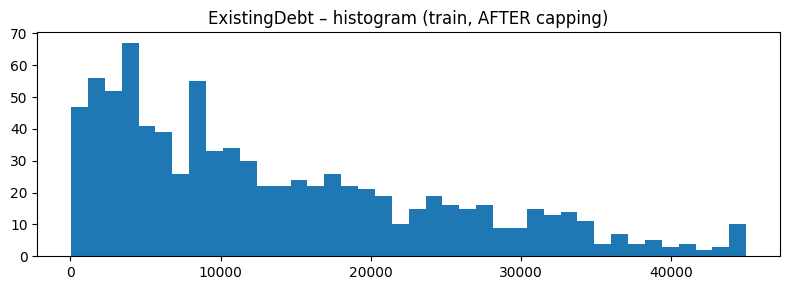

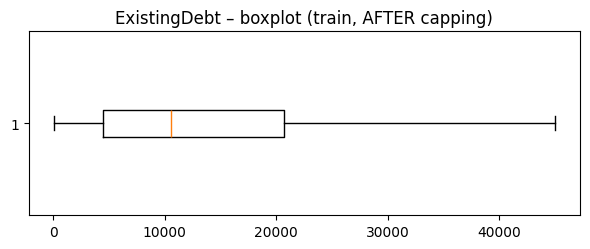

In [18]:
def frac_outliers_after(df, caps):
    fracs = {}
    for c in num_cols:
        low, high = caps[c]
        fracs[c] = ((df[c] < low) | (df[c] > high)).mean()
    return pd.Series(fracs).sort_values(ascending=False)

print("Outlier fraction before (top 10):")
display(outlier_table.set_index("column")["frac_outliers"].head(10))
print("\nOutlier fraction AFTER capping (train):")
display(frac_outliers_after(train_cap, caps).head(10))

for c in top_cols:
    fig = plt.figure(figsize=(8,3))
    plt.hist(train_cap[c].dropna(), bins=40)
    plt.title(f"{c} – histogram (train, AFTER capping)")
    plt.tight_layout(); plt.savefig(VIZ/f"hist_after_{c}.png", dpi=150); plt.show()

    fig = plt.figure(figsize=(6,2.6))
    plt.boxplot(train_cap[c].dropna(), vert=False)
    plt.title(f"{c} – boxplot (train, AFTER capping)")
    plt.tight_layout(); plt.savefig(VIZ/f"box_after_{c}.png", dpi=150); plt.show()


**Encoding**

In [19]:
import pandas as pd, numpy as np, pathlib, joblib
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

OUT = pathlib.Path("results/outputs")
TARGET = "Default"

train = pd.read_csv(OUT/"train_outliers_capped.csv")
val   = pd.read_csv(OUT/"val_outliers_capped.csv")
test  = pd.read_csv(OUT/"test_outliers_capped.csv")

X_train, y_train = train.drop(columns=[TARGET]), train[TARGET].astype(int)
X_val,   y_val   = val.drop(columns=[TARGET]),   val[TARGET].astype(int)
X_test,  y_test  = test.drop(columns=[TARGET]),  test[TARGET].astype(int)

num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]
print(f"Numeric: {len(num_cols)} | Categorical: {len(cat_cols)}")

# numeric-only preprocessor
pre = ColumnTransformer(
    transformers=[("num", Pipeline([("impute", SimpleImputer(strategy="median"))]), num_cols)],
    remainder="drop",
    verbose_feature_names_out=False
)

Xtr = pre.fit_transform(X_train)
Xv  = pre.transform(X_val)
Xt  = pre.transform(X_test)

feat_names = list(num_cols)  # numeric-only
pd.DataFrame(Xtr, columns=feat_names).assign(**{TARGET: y_train.values}).to_csv(OUT/"train_encoded.csv", index=False)
pd.DataFrame(Xv,  columns=feat_names).assign(**{TARGET: y_val.values}).to_csv(OUT/"val_encoded.csv",   index=False)
pd.DataFrame(Xt,  columns=feat_names).assign(**{TARGET: y_test.values}).to_csv(OUT/"test_encoded.csv",  index=False)
joblib.dump(pre, OUT/"preprocessor_cats.joblib")
print("Saved numeric-only encoded files.")


Numeric: 7 | Categorical: 0
Saved numeric-only encoded files.


In [20]:
import pandas as pd, pathlib
OUT = pathlib.Path("results/outputs")

for f in ["train_encoded.csv","val_encoded.csv","test_encoded.csv"]:
    df = pd.read_csv(OUT/f)
    print(f, df.shape, "| target present? ->", "Default" in df.columns)

# peek features
pd.read_csv(OUT/"train_encoded.csv").head()


train_encoded.csv (862, 8) | target present? -> True
val_encoded.csv (150, 8) | target present? -> True
test_encoded.csv (150, 8) | target present? -> True


,CustomerID,Age,AnnualIncome,LoanAmount,CreditScore,LoanTerm,ExistingDebt,Default
0,944.0,61.0,89659.0,29759.0,801.0,36.0,21856.0,0
1,200.0,61.0,49569.0,45087.0,452.0,12.0,12558.0,1
2,778.0,38.0,97010.0,19387.0,444.0,36.0,11979.0,1
3,366.0,22.0,83605.0,11322.0,447.0,24.0,7447.0,1
4,392.0,28.0,95022.0,25231.0,330.0,12.0,2835.0,1


**Normalization / scaling**

In [21]:
import pandas as pd, numpy as np, pathlib, os, joblib, matplotlib.pyplot as plt
from pathlib import Path
OUT = Path("results/outputs"); OUT.mkdir(parents=True, exist_ok=True)

# --- config ---
TARGET = "Default"              # change if your label name differs
USE_BALANCED_TRAIN = True       # prefer train_balanced_over/under.csv when available

# helper: return first existing path from a list of filenames (under OUT/)
def pick(*names):
    for n in names:
        p = OUT / n
        if p.exists():
            return p
    return None

# prefer newest stage → oldest
_candidates_common = [
    "train_encoded.csv", "val_encoded.csv", "test_encoded.csv",
    "train_scaled_standard.csv", "val_scaled_standard.csv", "test_scaled_standard.csv",
    "train_feature_engineered.csv", "val_feature_engineered.csv", "test_feature_engineered.csv",
    "train_outliers_capped_log.csv", "val_outliers_capped_log.csv", "test_outliers_capped_log.csv",
    "train_outliers_capped.csv", "val_outliers_capped.csv", "test_outliers_capped.csv",
    "train_missing_handled.csv", "val_missing_handled.csv", "test_missing_handled.csv",
    "train_split.csv", "val_split.csv", "test_split.csv",
]

# choose files
p_train = pick("train_encoded.csv", "train_scaled_standard.csv", "train_feature_engineered.csv",
               "train_outliers_capped_log.csv", "train_outliers_capped.csv",
               "train_missing_handled.csv", "train_split.csv")
p_val   = pick("val_encoded.csv", "val_scaled_standard.csv", "val_feature_engineered.csv",
               "val_outliers_capped_log.csv", "val_outliers_capped.csv",
               "val_missing_handled.csv", "val_split.csv")
p_test  = pick("test_encoded.csv", "test_scaled_standard.csv", "test_feature_engineered.csv",
               "test_outliers_capped_log.csv", "test_outliers_capped.csv",
               "test_missing_handled.csv", "test_split.csv")

# optional: prefer balanced TRAIN if available (only swaps TRAIN; val/test untouched)
if USE_BALANCED_TRAIN:
    p_bal = pick("train_balanced_over.csv") or pick("train_balanced_under.csv")
    if p_bal is not None:
        p_train = p_bal

assert p_train and p_val and p_test, "Could not find split/processed files under results/outputs/. Run earlier steps first."

train = pd.read_csv(p_train)
val   = pd.read_csv(p_val)
test  = pd.read_csv(p_test)
print("Loaded files:")
print("  TRAIN ->", p_train.name)
print("  VAL   ->", p_val.name)
print("  TEST  ->", p_test.name)

# ensure TARGET exists (attempt case-insensitive auto-fix if not)
if TARGET not in train.columns:
    cand = next((c for c in train.columns if c.lower() == TARGET.lower()), None)
    if cand:
        TARGET = cand
    else:
        # last resort: try to guess by common names
        guess = next((c for c in train.columns if c.lower() in ["default","label","target","is_default"]), None)
        assert guess is not None, "TARGET not found; set TARGET to your label column name."
        TARGET = guess

print("TARGET column set to:", TARGET)
assert TARGET in train.columns, f"{TARGET} not found in train."


Loaded files:
  TRAIN -> train_balanced_over.csv
  VAL   -> val_encoded.csv
  TEST  -> test_encoded.csv
TARGET column set to: Default


In [22]:
# separate features/labels
X_train = train.drop(columns=[TARGET]).copy()
y_train = train[TARGET].astype(int).copy()
X_val   = val.drop(columns=[TARGET]).copy()
y_val   = val[TARGET].astype(int).copy()
X_test  = test.drop(columns=[TARGET]).copy()
y_test  = test[TARGET].astype(int).copy()

# identify numeric vs categorical
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

print("Numeric columns to scale:", len(num_cols))
print("Categorical columns untouched:", len(cat_cols))


Numeric columns to scale: 7
Categorical columns untouched: 0


In [23]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()  # mean=0, std=1

X_train_std = X_train.copy()
X_val_std   = X_val.copy()
X_test_std  = X_test.copy()

# fit only on TRAIN numeric columns
X_train_std[num_cols] = std_scaler.fit_transform(X_train[num_cols])
X_val_std[num_cols]   = std_scaler.transform(X_val[num_cols])
X_test_std[num_cols]  = std_scaler.transform(X_test[num_cols])

# quick check: train numeric columns mean≈0, std≈1
means = X_train_std[num_cols].mean().round(3)
stds  = X_train_std[num_cols].std(ddof=0).round(3)
print("TRAIN (after StandardScaler) mean≈0?\n", means.head(8))
print("TRAIN (after StandardScaler) std≈1?\n", stds.head(8))

# save scaler + datasets
joblib.dump(std_scaler, OUT/"scaler_standard.pkl")
train_std = X_train_std.copy(); train_std[TARGET] = y_train.values
val_std   = X_val_std.copy();   val_std[TARGET]   = y_val.values
test_std  = X_test_std.copy();  test_std[TARGET]  = y_test.values

train_std.to_csv(OUT/"train_scaled_standard.csv", index=False)
val_std.to_csv(  OUT/"val_scaled_standard.csv",   index=False)
test_std.to_csv( OUT/"test_scaled_standard.csv",  index=False)
print("Saved StandardScaler outputs to results/outputs/*.csv and scaler_standard.pkl")


TRAIN (after StandardScaler) mean≈0?
 CustomerID      0.0
Age             0.0
AnnualIncome    0.0
LoanAmount      0.0
CreditScore    -0.0
LoanTerm        0.0
ExistingDebt   -0.0
dtype: float64
TRAIN (after StandardScaler) std≈1?
 CustomerID      1.0
Age             1.0
AnnualIncome    1.0
LoanAmount      1.0
CreditScore     1.0
LoanTerm        1.0
ExistingDebt    1.0
dtype: float64
Saved StandardScaler outputs to results/outputs/*.csv and scaler_standard.pkl


Visualizing columns: ['CustomerID', 'Age', 'AnnualIncome']


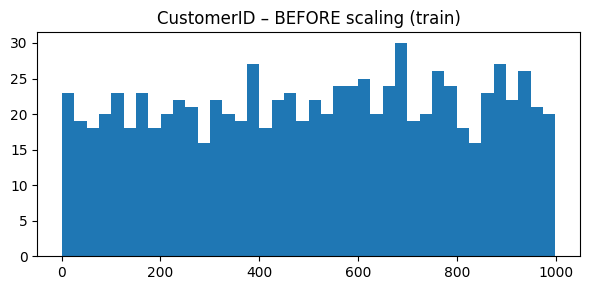

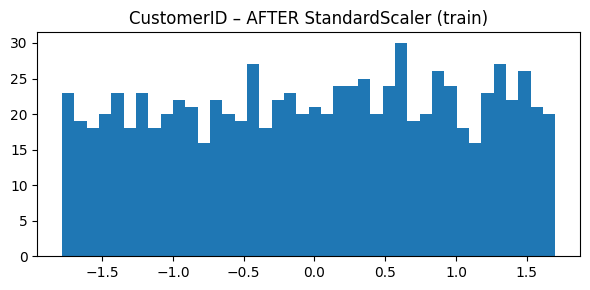

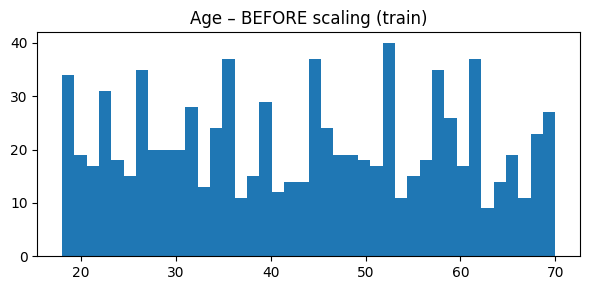

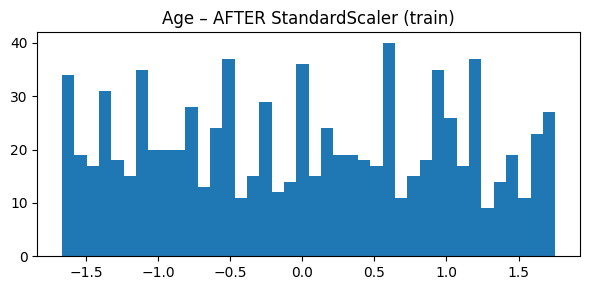

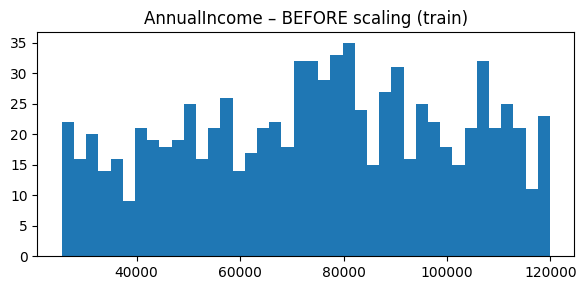

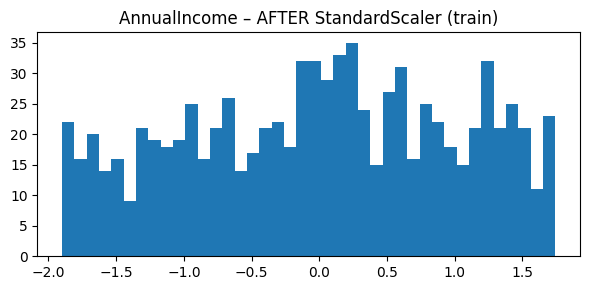

In [24]:
import matplotlib.pyplot as plt

sample_cols = num_cols[:3] if len(num_cols) >= 3 else num_cols
print("Visualizing columns:", sample_cols)

for c in sample_cols:
    # before
    plt.figure(figsize=(6,3))
    plt.hist(X_train[c].dropna(), bins=40)
    plt.title(f"{c} – BEFORE scaling (train)")
    plt.tight_layout(); plt.show()
    # after StandardScaler
    plt.figure(figsize=(6,3))
    plt.hist(X_train_std[c].dropna(), bins=40)
    plt.title(f"{c} – AFTER StandardScaler (train)")
    plt.tight_layout(); plt.show()


**Feature selection**

In [25]:
import numpy as np
import pandas as pd

def engineer_v2(df_train, df_val, df_test):
    Xtr, Xv, Xt = df_train.copy(), df_val.copy(), df_test.copy()

    # --- 0) Ensure no 'category' dtype columns block assignments ---
    for X in (Xtr, Xv, Xt):
        for c in X.select_dtypes(include=['category']).columns:
            X[c] = X[c].astype(str)  # drop categorical dtype

    # --- 0b) Helper: coerce potential numeric sources to numeric (no crash on strings) ---
    def to_num(X, col):
        if col and col in X.columns:
            return pd.to_numeric(X[col], errors='coerce')
        return None

    inc_tr = to_num(Xtr, C_INCOME)
    loan_tr = to_num(Xtr, C_LOAN_AMT)
    lim_tr = to_num(Xtr, C_LIMIT)
    bal_tr = to_num(Xtr, C_BAL)
    util_tr = to_num(Xtr, C_UIL)
    inst_tr = to_num(Xtr, C_INSTALL)

    # --- 1) Ratios & rates (fit-free, applied columnwise) ---
    # Debt-to-Income: installment / income
    if C_INSTALL and C_INCOME:
        for X in (Xtr, Xv, Xt):
            inst = to_num(X, C_INSTALL)
            inc  = to_num(X, C_INCOME)
            if inst is not None and inc is not None:
                X["dti_install"] = inst / inc.replace(0, np.nan)

    # Loan-to-Income
    if C_LOAN_AMT and C_INCOME:
        for X in (Xtr, Xv, Xt):
            loan = to_num(X, C_LOAN_AMT)
            inc  = to_num(X, C_INCOME)
            if loan is not None and inc is not None:
                X["loan_to_income"] = loan / inc.replace(0, np.nan)

    # Balance-to-Limit (utilization proxy)
    if C_BAL and C_LIMIT:
        for X in (Xtr, Xv, Xt):
            bal = to_num(X, C_BAL)
            lim = to_num(X, C_LIMIT)
            if bal is not None and lim is not None:
                X["bal_to_limit"] = bal / lim.replace(0, np.nan)

    # Existing utilization column (clip)
    if C_UIL and C_UIL in Xtr.columns:
        for X in (Xtr, Xv, Xt):
            util = to_num(X, C_UIL)
            if util is not None:
                X["util_capped"] = util.clip(lower=0, upper=1.5)

    # --- 2) Binning (creates NEW categorical columns; no fillna with numbers) ---
    if C_AGE and C_AGE in Xtr.columns:
        bins = [0, 21, 25, 30, 35, 45, 55, 65, np.inf]
        labels = ["<=21","22-25","26-30","31-35","36-45","46-55","56-65","65+"]
        for X in (Xtr, Xv, Xt):
            X["age_band"] = pd.cut(pd.to_numeric(X[C_AGE], errors='coerce'),
                                   bins=bins, labels=labels, right=True, include_lowest=True)

    if C_SCORE and C_SCORE in Xtr.columns:
        bins = [0, 580, 620, 660, 700, 740, 780, 900]
        labels = ["<580","580-619","620-659","660-699","700-739","740-779","780+"]
        for X in (Xtr, Xv, Xt):
            X["score_band"] = pd.cut(pd.to_numeric(X[C_SCORE], errors='coerce'),
                                     bins=bins, labels=labels, right=True, include_lowest=True)

    # --- 3) Frequency (count) encoding for ALL categorical/object columns ---
    # Learn on TRAIN only; apply mapping; NEW numeric columns with suffix __freq
    cat_cols = Xtr.select_dtypes(exclude=[np.number]).columns.tolist()
    cat_cols = [c for c in cat_cols if c != TARGET]
    freq_maps = {}
    for c in cat_cols:
        freq = Xtr[c].astype(str).value_counts(dropna=False)
        freq_maps[c] = freq
        for X in (Xtr, Xv, Xt):
            X[f"{c}__freq"] = X[c].astype(str).map(freq).fillna(0).astype(float)

    # --- 4) Rare-category grouping into "__OTHER__" (strings only, no numbers) ---
    for c in cat_cols:
        freq = freq_maps[c]
        cutoff = max(2, int(0.01 * len(Xtr)))  # <=1% or <=2 rows
        rare = set(freq[freq <= cutoff].index.astype(str))

        def group_to_other(s):
            s = s.astype(str)
            return s.where(~s.isin(rare), other="__OTHER__")

        for X in (Xtr, Xv, Xt):
            X[f"{c}__grp"] = group_to_other(X[c])

    # --- 5) Simple interactions (numeric only) ---
    pairs = []
    if C_INCOME and C_LOAN_AMT: pairs.append((C_LOAN_AMT, C_INCOME, "loan_x_income"))
    if C_BAL and C_LIMIT:       pairs.append((C_BAL, C_LIMIT, "bal_x_limit"))
    for a,b,name in pairs:
        for X in (Xtr, Xv, Xt):
            va = pd.to_numeric(X[a], errors='coerce') if a in X.columns else None
            vb = pd.to_numeric(X[b], errors='coerce') if b in X.columns else None
            if va is not None and vb is not None:
                X[name] = va * vb

    # --- 6) Clean infinities produced by divisions ---
    for X in (Xtr, Xv, Xt):
        X.replace([np.inf, -np.inf], np.nan, inplace=True)

    return Xtr, Xv, Xt, {"cat_cols": cat_cols}


In [27]:
# --- Detect common finance columns in your data (sets the C_* variables engineer_v2 uses) ---
import re

all_cols = list(train.columns)

def find_col(patterns, cols=all_cols):
    """Return the first column matching any regex pattern (case-insensitive), else None."""
    for pat in patterns:
        for c in cols:
            if re.search(pat, c, re.I):
                return c
    return None

C_INCOME   = find_col([r"\b(income|salary|annual[_ ]?inc)\b"])
C_LOAN_AMT = find_col([r"\b(loan[_ ]?amount|principal|disbursed|amt)\b"])
C_LIMIT    = find_col([r"\b(limit|credit[_ ]?limit)\b"])
C_BAL      = find_col([r"\b(balance|bal|outstanding)\b"])
C_UIL      = find_col([r"\b(util(?:ization|isation)?|util)\b"])
C_INSTALL  = find_col([r"\b(install(?:ment)?|emi|payment[_ ]?amount|monthly[_ ]?pay)\b"])
C_AGE      = find_col([r"\b(age|years[_ ]?old)\b"])
C_SCORE    = find_col([r"\b(credit[_ ]?score|score)\b"])

print("Detected columns:")
print("  INCOME     ->", C_INCOME)
print("  LOAN_AMT   ->", C_LOAN_AMT)
print("  LIMIT      ->", C_LIMIT)
print("  BALANCE    ->", C_BAL)
print("  UTIL       ->", C_UIL)
print("  INSTALL    ->", C_INSTALL)
print("  AGE        ->", C_AGE)
print("  SCORE      ->", C_SCORE)


Detected columns:
  INCOME     -> None
  LOAN_AMT   -> LoanAmount
  LIMIT      -> None
  BALANCE    -> None
  UTIL       -> None
  INSTALL    -> None
  AGE        -> Age
  SCORE      -> CreditScore


In [34]:
Xtr = train.drop(columns=[TARGET]); ytr = train[TARGET]
Xv  = val.drop(columns=[TARGET]);   yv  = val[TARGET]
Xt  = test.drop(columns=[TARGET]);  yt  = test[TARGET]

Xtr_fe, Xv_fe, Xt_fe, meta = engineer_v2(Xtr, Xv, Xt)

train_fe = Xtr_fe.copy(); train_fe[TARGET] = ytr.values
val_fe   = Xv_fe.copy();  val_fe[TARGET]   = yv.values
test_fe  = Xt_fe.copy();  test_fe[TARGET]  = yt.values


In [32]:
# --- 0) Setup & find inputs ---
import pandas as pd, numpy as np, pathlib, re, os

OUT = pathlib.Path("results/outputs"); OUT.mkdir(parents=True, exist_ok=True)
TARGET = "Default"  # change if your label is different

def pick(*names):
    for n in names:
        p = OUT/n
        if p.exists(): return p
    return None

p_train = pick("train_outliers_capped.csv","train_missing_handled.csv","train_split.csv")
p_val   = pick("val_outliers_capped.csv","val_missing_handled.csv","val_split.csv")
p_test  = pick("test_outliers_capped.csv","test_missing_handled.csv","test_split.csv")
assert p_train and p_val and p_test, "Upstream files not found. Run earlier steps first."

train = pd.read_csv(p_train); val = pd.read_csv(p_val); test = pd.read_csv(p_test)
assert TARGET in train.columns, f"{TARGET} not in train."

# --- 1) Column detection used by engineer_v2 ---
all_cols = list(train.columns)
def find_col(patterns, cols=all_cols):
    for pat in patterns:
        for c in cols:
            if re.search(pat, c, re.I): return c
    return None

C_INCOME   = find_col([r"\b(income|salary|annual[_ ]?inc)\b"])
C_LOAN_AMT = find_col([r"\b(loan[_ ]?amount|principal|disbursed|amt)\b"])
C_LIMIT    = find_col([r"\b(limit|credit[_ ]?limit)\b"])
C_BAL      = find_col([r"\b(balance|bal|outstanding)\b"])
C_UIL      = find_col([r"\b(util(?:ization|isation)?|util)\b"])
C_INSTALL  = find_col([r"\b(install(?:ment)?|emi|payment[_ ]?amount|monthly[_ ]?pay)\b"])
C_AGE      = find_col([r"\b(age|years[_ ]?old)\b"])
C_SCORE    = find_col([r"\b(credit[_ ]?score|score)\b"])

# --- 2) Robust feature engineering (engineer_v2) ---
def engineer_v2(df_train, df_val, df_test):
    Xtr, Xv, Xt = df_train.copy(), df_val.copy(), df_test.copy()

    # drop pandas 'category' dtype (prevents setitem errors)
    for X in (Xtr, Xv, Xt):
        for c in X.select_dtypes(include=['category']).columns:
            X[c] = X[c].astype(str)

    def to_num(X, col):
        if col and col in X.columns:
            return pd.to_numeric(X[col], errors='coerce')
        return None

    # ratios
    if C_INSTALL and C_INCOME:
        for X in (Xtr, Xv, Xt):
            inst = to_num(X, C_INSTALL); inc = to_num(X, C_INCOME)
            if inst is not None and inc is not None:
                X["dti_install"] = inst / inc.replace(0, np.nan)

    if C_LOAN_AMT and C_INCOME:
        for X in (Xtr, Xv, Xt):
            loan = to_num(X, C_LOAN_AMT); inc = to_num(X, C_INCOME)
            if loan is not None and inc is not None:
                X["loan_to_income"] = loan / inc.replace(0, np.nan)

    if C_BAL and C_LIMIT:
        for X in (Xtr, Xv, Xt):
            bal = to_num(X, C_BAL); lim = to_num(X, C_LIMIT)
            if bal is not None and lim is not None:
                X["bal_to_limit"] = bal / lim.replace(0, np.nan)

    if C_UIL:
        for X in (Xtr, Xv, Xt):
            util = to_num(X, C_UIL)
            if util is not None:
                X["util_capped"] = util.clip(0, 1.5)

    # bins
    if C_AGE:
        bins = [0,21,25,30,35,45,55,65,np.inf]
        labels = ["<=21","22-25","26-30","31-35","36-45","46-55","56-65","65+"]
        for X in (Xtr, Xv, Xt):
            X["age_band"] = pd.cut(pd.to_numeric(X[C_AGE], errors='coerce'),
                                   bins=bins, labels=labels, include_lowest=True, right=True)

    if C_SCORE:
        bins = [0,580,620,660,700,740,780,900]
        labels = ["<580","580-619","620-659","660-699","700-739","740-779","780+"]
        for X in (Xtr, Xv, Xt):
            X["score_band"] = pd.cut(pd.to_numeric(X[C_SCORE], errors='coerce'),
                                     bins=bins, labels=labels, include_lowest=True, right=True)

    # frequency encoding (fit on train)
    cat_cols = Xtr.select_dtypes(exclude=[np.number]).columns.tolist()
    cat_cols = [c for c in cat_cols if c != TARGET]
    freq_maps = {}
    for c in cat_cols:
        freq = Xtr[c].astype(str).value_counts(dropna=False)
        freq_maps[c] = freq
        for X in (Xtr, Xv, Xt):
            X[f"{c}__freq"] = X[c].astype(str).map(freq).fillna(0).astype(float)

    # rare grouping
    for c in cat_cols:
        freq = freq_maps[c]
        cutoff = max(2, int(0.01*len(Xtr)))
        rare = set(freq[freq <= cutoff].index.astype(str))
        def group_other(s):
            s = s.astype(str)
            return s.where(~s.isin(rare), "__OTHER__")
        for X in (Xtr, Xv, Xt):
            X[f"{c}__grp"] = group_other(X[c])

    # simple interactions
    pairs = []
    if C_INCOME and C_LOAN_AMT: pairs.append((C_LOAN_AMT, C_INCOME, "loan_x_income"))
    if C_BAL and C_LIMIT:       pairs.append((C_BAL, C_LIMIT, "bal_x_limit"))
    for a,b,name in pairs:
        for X in (Xtr, Xv, Xt):
            va = to_num(X, a); vb = to_num(X, b)
            if va is not None and vb is not None:
                X[name] = va * vb

    for X in (Xtr, Xv, Xt):
        X.replace([np.inf,-np.inf], np.nan, inplace=True)

    return Xtr, Xv, Xt, {"cat_cols": cat_cols}

# --- 3) Apply FE & save ---
Xtr = train.drop(columns=[TARGET]); ytr = train[TARGET]
Xv  = val.drop(columns=[TARGET]);   yv  = val[TARGET]
Xt  = test.drop(columns=[TARGET]);  yt  = test[TARGET]

Xtr_fe, Xv_fe, Xt_fe, meta = engineer_v2(Xtr, Xv, Xt)

train_fe = Xtr_fe.copy(); train_fe[TARGET] = ytr.values
val_fe   = Xv_fe.copy();  val_fe[TARGET]   = yv.values
test_fe  = Xt_fe.copy();  test_fe[TARGET]  = yt.values

train_fe.to_csv(OUT/"train_feature_engineered.csv", index=False)
val_fe.to_csv(  OUT/"val_feature_engineered.csv",   index=False)
test_fe.to_csv( OUT/"test_feature_engineered.csv",  index=False)
print("Saved FE files:",
      OUT/"train_feature_engineered.csv",
      OUT/"val_feature_engineered.csv",
      OUT/"test_feature_engineered.csv")

# --- 4) Now load to dfx safely ---
dfx = pd.read_csv(OUT/"train_feature_engineered.csv")
print("Loaded dfx:", dfx.shape)
dfx.dtypes.head(20)


Saved FE files: results/outputs/train_feature_engineered.csv results/outputs/val_feature_engineered.csv results/outputs/test_feature_engineered.csv
Loaded dfx: (862, 14)


,0
CustomerID,float64
Age,float64
AnnualIncome,float64
LoanAmount,float64
CreditScore,float64
LoanTerm,float64
ExistingDebt,float64
age_band,object
score_band,object
age_band__freq,float64
